## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# In this path we will also store temporary data and final results.
PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=16

In [3]:
# Tfms stands for transformations, tfms_from_model takes care of:
# resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

# ImageClassifierData reads data from a provided path and creates a dataset ready for training.
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4, test_name='test')

# Train only last layer
# Uncoment if training form scratch
# learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

### Start training the only last layer

- lr = 0.02
- number of cycles = 1 

In [ ]:
# Train last layer from precomputed activations for 1 epochs.
learn.fit(1e-2, 1)

# By default when we create a learner, it sets all but the last layer to frozen. 
learn.precompute=False

### Retrain our last layer with SGDR 

(stochastic gradient descent with restarts) is a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit().

- lr = 0.01
- number of cycles = 2
- cycle len = 1 means we reset lr at each epoch, 2 = reset lr after 2 epochs, etc...

In [ ]:
# Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1.
learn.fit(1e-2, 2, cycle_len=1)

### Train all layers (Fine-tuning and differential learning rate annealing)
Now that we have a good final layer trained, we can try fine-tuning the other layers, we also set different lr for the first layers (small lr as it's already trained on ImageNet), middle and last.

In [ ]:
# Unfreeze all layers.
learn.unfreeze()

# Differential learning rate
# Set earlier layers to 3x-10x lower learning rate than next higher layer.
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2).
# Where cycle_mult=2 is multiplying each time training batches by 2 only the final layer.

learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.save('224_all_101')

In [4]:
# Set precompute to False as this how we saved our model
# Load our model
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.load('224_all_101')

In [13]:
%time log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy(probs,y)

CPU times: user 2min 27s, sys: 14.4 s, total: 2min 42s
Wall time: 1min 20s


0.99350000000000005

In [15]:
probs.shape

(2000, 2)

### Make a prediction and submision file

In [16]:
#log_preds,y = learn.TTA(is_test=True)
%time log_preds_test = learn.predict(is_test=True)

CPU times: user 2min 32s, sys: 18.3 s, total: 2min 50s
Wall time: 1min 40s


In [51]:
log_preds_test2 = log_preds_test[:,1]
print(log_preds_test2[23])

# Transform to probabilities our log predictions
log_preds_test3 = np.exp(log_preds_test2)
print(log_preds_test3[23])


#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .98 and all zeros with .02
isdog = np.clip(log_preds_test3, 0.02, 0.98)
print(isdog[23:40])

-8.61212
0.000181887
[ 0.02  0.02  0.02  0.98  0.02  0.98  0.98  0.98  0.98  0.02  0.98  0.02  0.02  0.98  0.98  0.98  0.98]


In [53]:
#Extract imageIds from the filenames in our test/unknown directory 
import glob
import re

ids = []
for filename in glob.glob('data/dogscats/test/*.jpg'):
    # Extract only number as list of chars
    filename = re.findall('\d+', filename)
    # Convert to int and 
    ids.append(int(filename[0]))
    
ids = np.array(ids)

In [54]:
ids.shape

(12500,)

In [55]:
isdog.shape

(12500,)

In [56]:
subm = np.stack([ids,isdog], axis=1)
# Insert the column id from the sample_submission at the start of the data frame
np.savetxt('submission.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

## Analyzing results

In [57]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[989  11]
 [  2 998]]


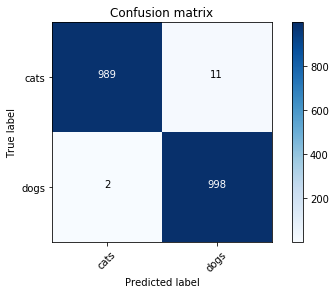

In [58]:
plot_confusion_matrix(cm, data.classes)

In [59]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


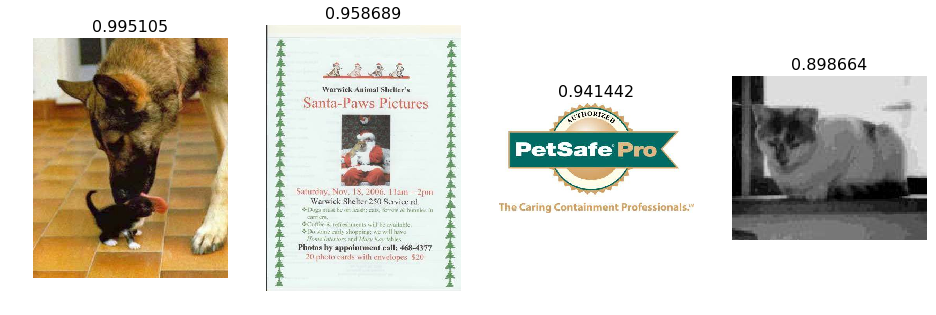

In [60]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


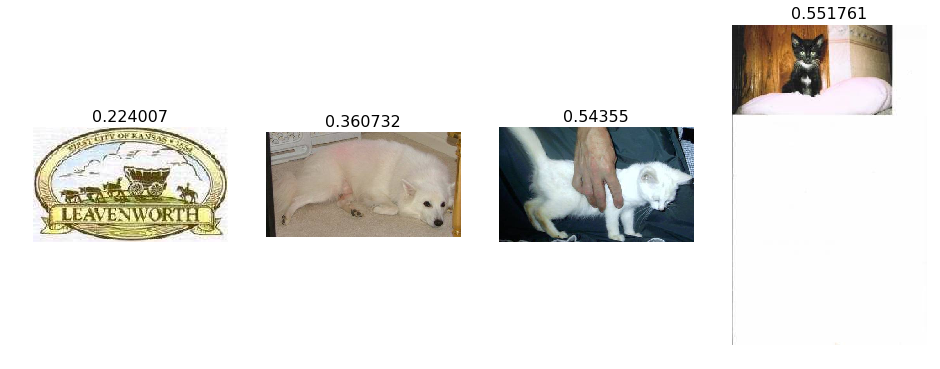

In [61]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")